In [9]:
require 'nn'
require 'cunn'
require 'image'
matio = require 'matio'

nUtils = dofile('../modules/netUtils.lua')
vUtils = dofile('../modules/visUtils.lua')
mUtils = dofile('../modules/meshUtils.lua')
primitives = dofile('../modules/primitives.lua')
demoUtils = dofile('../demo/demoUtils.lua')

params = {}
params.gridSize = 32 --we trained our CNNs to predict using this voxel grid size input
params.gridBound = 0.5 --the meshes are normalized between [-gridBund, gridBound]
params.primTypes = {'Cu','Nu'} -- the trained CNNs outputs each primitive as a 'Cuboid' or 'Null' (non-existent)
blendFile = '../renderer/model.blend' -- needed for rendering
blenderExec = '/usr/bin/blender'

In [10]:
params.synset = '03001627' --synset id for chairs
params.name = 'test_init' --name of the CNN
--params.name = 'chairNet' --name of the CNN
params.numTrainIter = 20000
params.modelsDir = '../cachedir/shapenet/chamferData/' .. params.synset .. '/test/' --directory where the .mat files containing input voxels are stored.
params.visMeshesDir = '../cachedir/resultsDir/' .. params.name .. '/' --directory where the meshes, rendrings should be saved
paths.mkdir(params.visMeshesDir)

In [11]:
local snapshotDir = '../cachedir/snapshots/' .. params.name -- directory where CNN is saved
if(not paths.filep(snapshotDir .. '/iter' .. tostring(params.numTrainIter) .. '.t7')) then
    local webLink = 'https://people.eecs.berkeley.edu/~shubhtuls/cachedir/primitives/chairNet/iter30000.t7'
    paths.mkdir(snapshotDir)
    require 'os'
    local command = string.format('wget %s; mv iter30000.t7 %s/', webLink, snapshotDir)
    print(command)
    os.execute(command)
end

local snapshotDir10 = '../cachedir/snapshots/' .. 'test_image' -- directory where CNN is saved
netPred10 = torch.load(snapshotDir10 .. '/iter' .. tostring(params.numTrainIter) .. '.t7')
netPred10:evaluate()
netPred10:apply(nUtils.setTestMode)

netPred20 = torch.load(snapshotDir .. '/iter' .. tostring(params.numTrainIter) .. '.t7')
netPred20:evaluate()
netPred20:apply(nUtils.setTestMode)

In [12]:
---------Data Loading----------
-------------------------------

loadShape = function (name)

    modelName = name .. '.mat' -- or '117c0e0aafc0c3f81015cdff13e6d9f3.mat' or '4aafa7600e0aacbf7b11ae648ea92233.mat'
    shapeVar = matio.load(paths.concat(params.modelsDir, modelName),{'Volume','vertices','faces'})
    volInp = torch.Tensor(2,1,params.gridSize ,params.gridSize, params.gridSize):fill(0)
    volInp[1]:copy(shapeVar.Volume:double())
    volInp = volInp:cuda()

    return volInp
end

loadImage = function (name)
    
    modelName = name .. '.png'
    img = image.load(paths.concat('/home/darwin/Projects/shape-prim/volumetricPrimitives/cachedir/shapenet/chamferData/03001627', 'img', modelName), 1, 'float')
    volInp = torch.Tensor(2,1,402, 402):fill(0)
    volInp[1]:copy(img)
    volInp = volInp:cuda()

    return volInp
end


In [13]:
---------Prediction------------
-------------------------------

predict = function (model, volInp, simplify)

    predParams = model:forward(volInp) -- Prediction of cuboid configuration
    partVols = {}

    for px = 1,#predParams do
        partVols[px] = mUtils.shapeVolume(predParams[px][1][1]:clone():double(), params.primTypes)
        predParams[px] = {
            predParams[px][1]:narrow(1,1,1):clone():double(),
            predParams[px][2]:narrow(1,1,1):clone():double(),
            predParams[px][3]:narrow(1,1,1):clone():double()
        }
    end

    --local shape, translation, quat = unpack(predParams[1])
    --shape = shape:view(-1)
    --translation = translation:view(-1)
    --quat = quat:clone():view(-1)
    --quat[1] = -quat[1]

    
    -- predParams[px][1] -> shape
    -- predParams[px][2] -> translation
    -- predParams[px][3] -> quat - rotation

    -- Simplification (remove parts which intersect with others a lot)
    if simplify then
        predParams, partVols = demoUtils.removeRedundantParts(predParams, partVols, params.primTypes)
    end
    
    return predParams, partVols
end

5a3ac1ba6f751bed79368d1198f406e7	


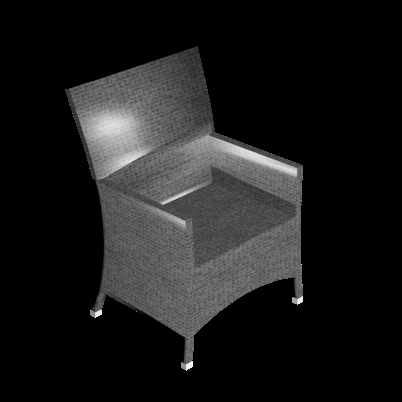

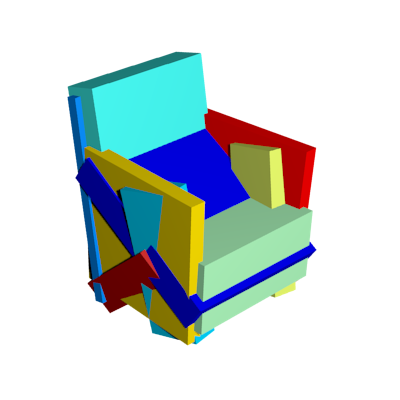

5a3ac1ba6f751bed79368d1198f406e7	


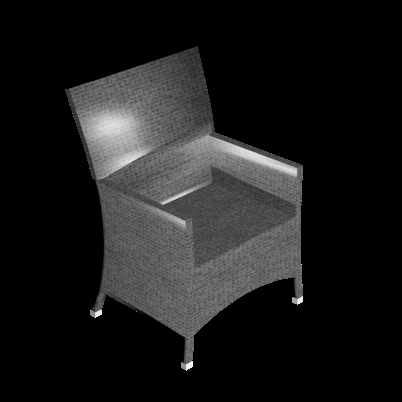

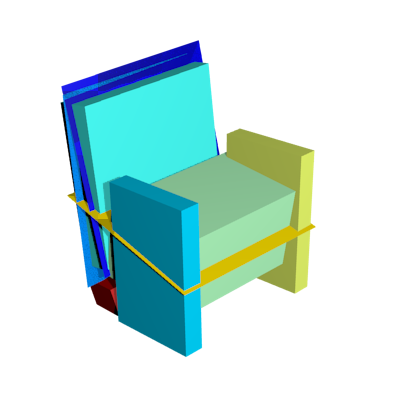

5ab67b30e17a2ed1c862eec8232fff1e	


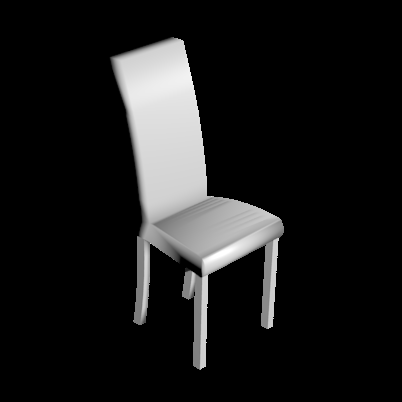

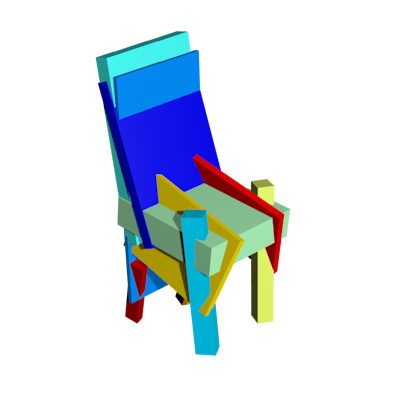

5ab67b30e17a2ed1c862eec8232fff1e	


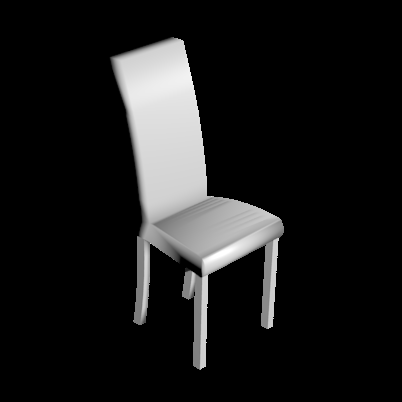

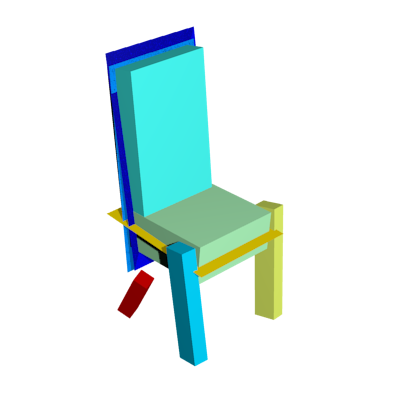

54237961055ef73782db9fca4b68095	


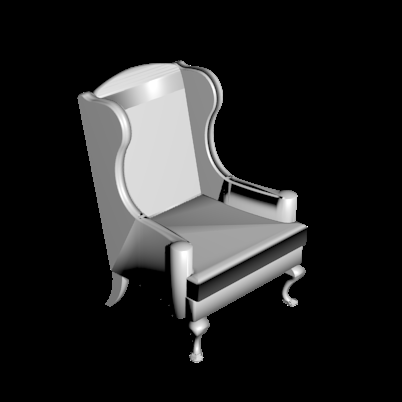

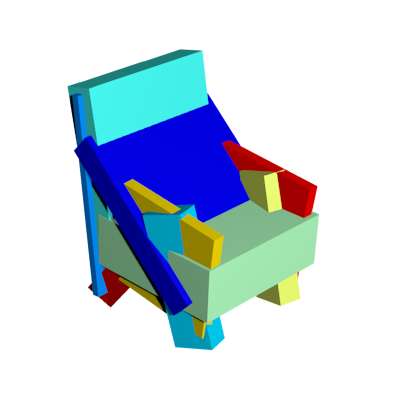

54237961055ef73782db9fca4b68095	


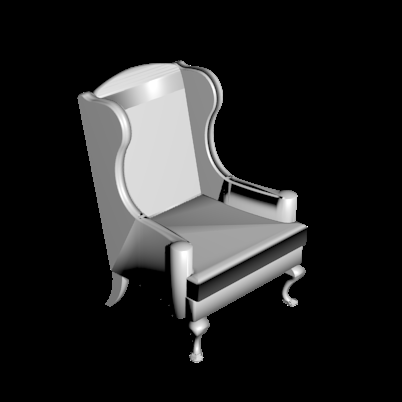

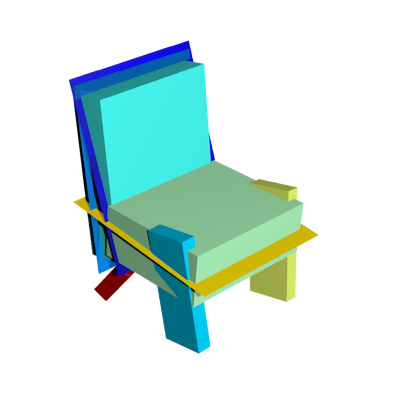

In [14]:
--------Visualization----------
-------------------------------
visualize = function (modelName, predParams, partVols)
    print(modelName)
    local imgsVis = torch.Tensor(2,3,400,400)
    -- The ground-truth mesh
    local mName = modelName:split('.mat$')[1]
    --local gtMesh = params.visMeshesDir .. mName .. '_gt.obj'
    --local gtPng = params.visMeshesDir .. mName .. '_gt.png'    
    --mUtils.writeObj(gtMesh, shapeVar.vertices, shapeVar.faces)
    --mUtils.renderMesh(blenderExec, blendFile, gtMesh, gtPng)
    --local im = image.crop(vUtils.RGBAtoRGB(image.load(gtPng)), 350, 1, 750, 401)
    local im = image.load(paths.concat('/home/darwin/Projects/shape-prim/volumetricPrimitives/cachedir/shapenet/chamferData/03001627', 'img', modelName .. '.png'), 1, 'float')
    itorch.image(im)
    
    --imgsVis[1]:copy(im)

    -- The predicted cuboid configuration
    local predMesh = params.visMeshesDir .. mName .. '_pred.obj'
    local predPng = params.visMeshesDir .. mName .. '_pred.png'
    mUtils.saveParts(predParams, predMesh , params.primTypes)
    mUtils.renderMesh(blenderExec, blendFile, predMesh, predPng)
    local im = image.crop(vUtils.RGBAtoRGB(image.load(predPng)), 350, 1, 750, 401)
    --imgsVis[1]:copy(im)
    itorch.image(im)

    -- The mesh parse inferred by computing for each mesh triangle the corresponding cuboid index
    --local parseMesh = params.visMeshesDir .. mName .. '_parse.obj'
    --local parsePng = params.visMeshesDir .. mName .. '_parse.png'

    --local faceInds = demoUtils.meshFaceInds(predParams, partVols, shapeVar, params.primTypes)
    --mUtils.saveParse(parseMesh, shapeVar.vertices, shapeVar.faces, faceInds:clone(), #predParams)
    --mUtils.renderMesh(blenderExec, blendFile, parseMesh, parsePng)
    --local im = image.crop(vUtils.RGBAtoRGB(image.load(parsePng)), 350, 1, 750, 401)
    --imgsVis[2]:copy(im)

    --itorch.image(imgsVis)
end

--chairs = {'713d651528ade2516bbe7b731c00d0e5','975d6db745442a755634c21965ee6bab','a56e201584ad5afb61ad1cb92b23bf5'}
chairs = {'5a3ac1ba6f751bed79368d1198f406e7','5ab67b30e17a2ed1c862eec8232fff1e','54237961055ef73782db9fca4b68095'}

for i,m in ipairs(chairs) do
    --chair1 = loadShape(m) 
    chair1 = loadImage(m)
    visualize(m, predict(netPred20, chair1, false))
    visualize(m, predict(netPred10, chair1, false))
    --visualize(predict(netPred10, chair1, true))
    --visualize(predict(netPred20, chair1, true))
end